In [29]:
import sys
sys.path.append('src/')

import spiceypy as spice
import coordinates as coord

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap

#### Useful constants for computations.

In [30]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

#### Ellipsoid parameters of the Earth.

In [31]:
a_ell = 6378137.0
c_ell = 6356752.314245
e_ell = np.sqrt(1 - c_ell ** 2  / a_ell ** 2)

In [32]:
R_sun  = 696000000.0
R_moon = 1737000.0

#### Load SPICE kernels needed for computation of the eclipse conditions. We need to know the position of the planets, and orientation of the Earth to project the shadow on the Moon on the Earth surface.

In [33]:
metakernel_path = 'SPICE/metakernel_eclipse.txt'
spice.furnsh(metakernel_path)

#### Period Definitions
- Draconic Period: time between successive node passes
- Anomalistic Period: time between successive pericenter passes
- Synodic Period: repeat period of the sun-earth-moon angle, new Moon to new Moon

In [34]:
month_synodic     = 29.530589
month_anomalistic = 27.554550
month_draconic    = 27.212221

#### Here we compute the ratio between the synodic time (integer number of synodic months) and the anomalistic/draconic periods. We then take the mod to determine hop close each ratio is to an integer.

In [35]:
n = np.arange(1,1000,1)

time_synodic     = n * month_synodic
n_anomalistic    = time_synodic / month_anomalistic
n_draconic       = time_synodic / month_draconic

# find modulo of 
rest_anomalistic = np.mod(n_anomalistic,1.0)
rest_draconic    = np.mod(n_draconic,1.0)

rest_anomalistic[rest_anomalistic > 0.5 ] = rest_anomalistic[rest_anomalistic > 0.5 ] - 1.0
rest_draconic[rest_draconic > 0.5 ] = rest_draconic[rest_draconic > 0.5 ] - 1.0

#### The total residual is the sum of of anomalistic and draconic residuals. If the total residual is small, then both the anomalisitc and draconic periods have aligned with the synodic time.

In [36]:
residual_total = np.abs(rest_draconic) + np.abs(rest_anomalistic)

#### Plot results and look for mimima

Text(0, 0.5, 'Total residual')

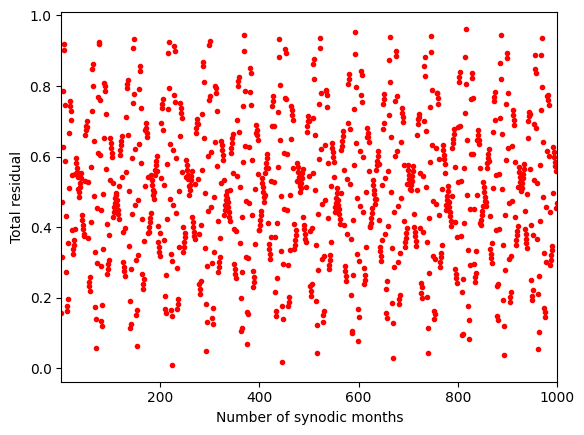

In [37]:
plt.figure
plt.plot(n, residual_total,'.r')
plt.xlim((1,1000))
plt.xlabel("Number of synodic months")
plt.ylabel("Total residual")

We can see that the residual is small at $n\approx220$. Lets find the exact value.

In [38]:
ind_sort = np.argsort(residual_total)

In [39]:
n[ind_sort[0]]

223

In [40]:
223 * month_synodic / month_anomalistic

238.99215726622282

In [41]:
223 * month_synodic / month_draconic

241.99867210397858

#### Declare start time and end time (UTC), between which we will get planetary positions.

In [ ]:
n_steps = 20
# we are going to get positions between these two dates
t_start = '2024 APR 08 16:17:22.0000'
t_end   = '2024 APR 08 20:17:22.0000'

#### Convert UTC times to ephemeris times.

In [99]:
# get et values one and two, we could vectorize str2et
et_start = spice.str2et(t_start)
et_end   = spice.str2et(t_end)

#### Generate array of times at which analysis will be conducted.

In [100]:
# get times
times = np.linspace(et_start, et_end, n_steps)

#### Initialize position/velocity data structures for the Sun and Moon.

In [45]:
state_sun  = np.zeros((6, len(times)))
state_moon = np.zeros((6, len(times)))

#### Populate the states for the Sun and Moon using SPICE kernels. Then, convert these positions into spherical coordinates (latitude & longitude).

In [46]:
#Run spkpos as a vectorized function
for i in range(len(times)):
    state_sun[:,i], _  = spice.spkez(10, times[i], 'ITRF93', "LT+S", 399)
    state_moon[:,i], _ = spice.spkez(301, times[i], 'ITRF93', "LT+S", 399)

state_sun  = state_sun * 1e3
state_moon = state_moon * 1e3

lon_sun, lat_sun, r_sun    = coord.cart2sph(state_sun[0,:], state_sun[1,:], state_sun[2,:])
lon_moon, lat_moon, r_moon = coord.cart2sph(state_moon[0,:], state_moon[1,:], state_moon[2,:])

#### Compute the angle between the Sun and Moon, as seen from the center of the Earth.
The Sun-Moon angle is $\theta = \mathrm{cos}^{-1}(\vec{r}_{Sun} \cdot  \vec{r}_{Moon}) / (|\vec{r}_{Sun}| \cdot |\vec{r}_{Moon}|$)

In [47]:
angle_SM = np.arccos((state_sun[0,:] * state_moon[0,:] +\
                      state_sun[1,:] * state_moon[1,:] +\
                      state_sun[2,:] * state_moon[2,:]) /  (r_sun * r_moon))

#### Plot results.

Text(0, 0.5, 'Angle between Sun and Moon [deg]')

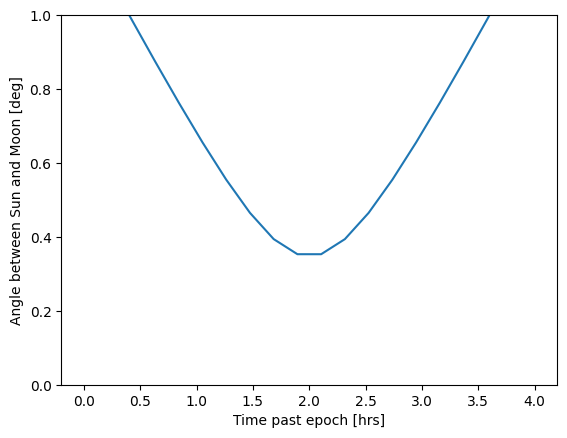

In [48]:
plt.plot((times - times[0])/3600,angle_SM * rad2deg)
plt.ylim((0,1))
plt.xlabel("Time past epoch [hrs]")
plt.ylabel("Angle between Sun and Moon [deg]")

The minimum angle between the Sun and Moon is about 0.4 degrees. This is less than the angle they cover in the sky (which is about 0.5 deg), indicating they overlap if viewed by an observer at the center of the Earth.

#### Compute the distance between the Sun and Moon.

In [49]:
r_MS = np.sqrt((state_sun[0,:] - state_moon[0,:]) ** 2 +\
               (state_sun[1,:] - state_moon[1,:]) ** 2 +
               (state_sun[2,:] - state_moon[2,:]) ** 2)

The lunar shadow can be modeled as a cone. The base of the cone is the Moon. Here, we compute the distance between the tip of the cone and the base.

$d_{\text{shadow}}=\frac{R_{\text{moon}} r_{\text{ms}}}{R_{\text{sun}} - R_{\text{moon}}}$

In [50]:
d_shadow = (R_moon * r_MS) / (R_sun - R_moon)

#### Compare the length of the cone and the distance betwen the Earth and Moon. The shadow length is greater, implying the shadow could intersect the Earth (if the angle is right).

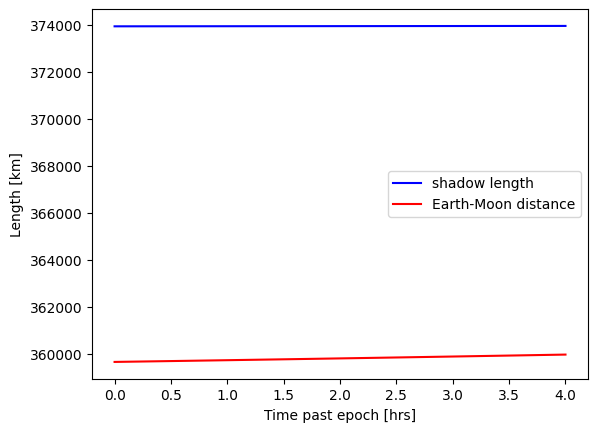

In [51]:
plt.figure()
plt.plot((times - times[0])/3600, d_shadow / 1e3,'-b',label='shadow length')
plt.plot((times - times[0])/3600, r_moon /1e3,'-r',label='Earth-Moon distance')
plt.xlabel("Time past epoch [hrs]")
plt.ylabel("Length [km]")
plt.legend()

The shadow length is greater, implying the shadow could intersect the Earth (if the angle is right).¶

#### Now, we compute the position of the shadow's tip.

## $\vec{r}_{\text{shadow}}=\vec{r}_{\text{moon}} + \frac{\vec{r}_{\text{moon}} - \vec{r}_{\text{sun}}}{r_{\text{ms}}}\cdot d_{\text{shadow}}$

In [52]:
pos_shadow_tip = state_moon[0:3,:] + (state_moon[0:3,:] - state_sun[0:3,:]) / r_MS * d_shadow

#### We define a function that determines if an arbitrary point is within the cone (shadow). Two conditions:
1. $ 0 < \text{proj}_{\text{cone direction}}\ p \cdot \text{cone direction} < \text{cone height}$   (symmetrical component)
2. $|p - \text{proj}_{\text{cone direction}}\ p - \text{cone tip}| < \text{cone radius}$            (orthogonal component)


In [53]:
def is_in_cone(p, cone_tip,cone_dir,cone_height,cone_base_radius):
    cone_dist = np.dot(p - cone_tip, cone_dir)
    if (0.0 < cone_dist) and (cone_dist < cone_height):
        cone_radius   = cone_dist / cone_height * cone_base_radius
        orth = p - cone_tip - cone_dist * cone_dir # cone dist - magnitude, cone_dir is the unit vector
        orth_distance = np.sqrt(orth[0] ** 2 + orth[1] ** 2 + orth[2] ** 2)
        if orth_distance < cone_radius:
            return 1
        else:
            return 0
    else:
        return 0

#### Create a partial geographic grid of locations around the United States.

In [54]:
L_grid          = np.linspace(-160.0,-40.0,360*2+1) * deg2rad
B_grid          = np.linspace(0.0,50.0,180*2+1)   * deg2rad
L_grid,B_grid   = np.meshgrid(L_grid,B_grid)
map_shape       = L_grid.shape
H_grid          = np.zeros(map_shape)

x_ell, y_ell, z_ell = coord.BLH2XYZ(B_grid, L_grid, H_grid, a_ell, e_ell)
lon_p, lat_p, _     = coord.cart2sph(x_ell, y_ell, z_ell)

#### Loop through locations to determine where the eclipse occurs through time (inside the cone).

In [55]:
eclipse_map   = np.zeros(map_shape)
for k in range(len(times)):

    h        = d_shadow[k]
    x        = pos_shadow_tip[:,k]
    v        = (state_moon[0:3,k] - x) / h

    for i in range(map_shape[0]):
        for j in range(map_shape[1]):
            sun_dist = np.arccos(np.sin(lat_sun[k]) * np.sin(lat_p[i,j]) + np.cos(lat_sun[k]) * np.cos(lat_p[i,j]) * np.cos(lon_sun[k] - lon_p[i,j]))
            if sun_dist < pi/2.0:
                p = np.array([x_ell[i,j],y_ell[i,j],z_ell[i,j]])
                eclipse_map[i,j] = eclipse_map[i,j] + is_in_cone(p, x, v, h, R_moon)

Text(0, 0.5, 'Latitude [deg]')

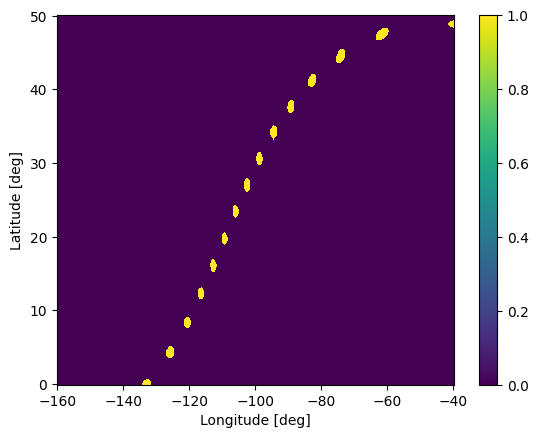

In [56]:
plt.figure()
plt.pcolor(L_grid * rad2deg, B_grid * rad2deg, eclipse_map)
plt.colorbar()
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")

#### Plot contours of the eclipse path on a Geographic plot.

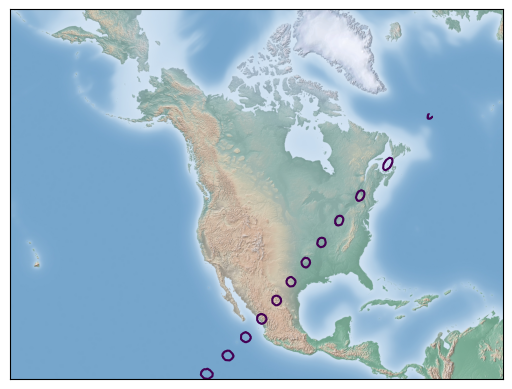

In [57]:
# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
map = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
map.shadedrelief()
x_map, y_map = map(L_grid * rad2deg, B_grid * rad2deg)
map.contour(x_map, y_map, eclipse_map, np.array([0.01]))
plt.show()

#### Declare Epoch start and end times using the Saros cycle (223 synodic months)

In [ ]:
n_steps = 20
# we are going to get positions between these two dates
t0 = '2024 APR 08 16:17:22.0000'

In [96]:
# get et values one and two, we could vectorize str2et
et_start = spice.str2et(t0) + 223.0 * month_synodic * 86400
et_end   = et_start + 3600 * 4

# get times
times = np.linspace(et_start, et_end, n_steps)

#### Now, we repeat the previous steps to acquire the positions of the Sun and Moon. These can be used to get the angle between these celestial bodies.

In [60]:
state_sun  = np.zeros((6, len(times)))
state_moon = np.zeros((6, len(times)))

#Run spkpos as a vectorized function
for i in range(len(times)):
    state_sun[:,i], _  = spice.spkez(10, times[i], 'ITRF93', "LT+S", 399)
    state_moon[:,i], _ = spice.spkez(301, times[i], 'ITRF93', "LT+S", 399)

state_sun  = state_sun * 1e3
state_moon = state_moon * 1e3

lon_sun, lat_sun, r_sun    = coord.cart2sph(state_sun[0,:], state_sun[1,:], state_sun[2,:])
lon_moon, lat_moon, r_moon = coord.cart2sph(state_moon[0,:], state_moon[1,:], state_moon[2,:])

r_MS = np.sqrt((state_sun[0,:] - state_moon[0,:]) ** 2 +\
               (state_sun[1,:] - state_moon[1,:]) ** 2 +
               (state_sun[2,:] - state_moon[2,:]) ** 2)

In [61]:
angle_SM = np.arccos((state_sun[0,:] * state_moon[0,:] +\
                      state_sun[1,:] * state_moon[1,:] +\
                      state_sun[2,:] * state_moon[2,:]) /  (r_sun * r_moon))

Text(0, 0.5, 'Angle between Sun and Moon [deg]')

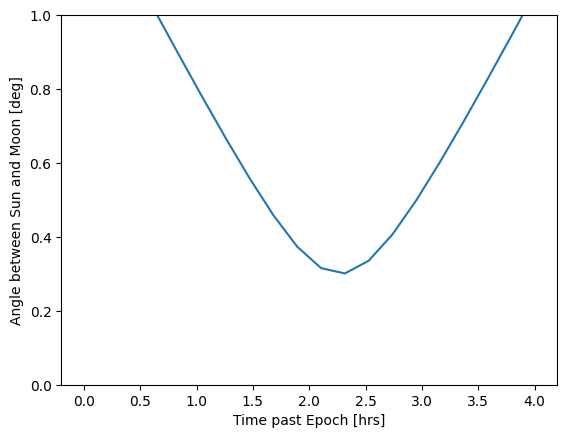

In [62]:
plt.plot((times - times[0])/3600,angle_SM * rad2deg)
plt.ylim((0,1))
plt.xlabel("Time past Epoch [hrs]")
plt.ylabel("Angle between Sun and Moon [deg]")

#### Now, we compute the shadow length (cone) once again. We also get the position of the shadow's tip.

In [63]:
d_shadow = (R_moon * r_MS) / (R_sun - R_moon)

In [64]:
pos_shadow_tip = state_moon[0:3,:] + (state_moon[0:3,:] - state_sun[0:3,:]) / r_MS * d_shadow

#### Generate a new grid of latitude/longitudes. Use the same process to determine if a location is within the cone.

In [65]:
L_grid_new          = L_grid - 120.0 * deg2rad
x_ell, y_ell, z_ell = coord.BLH2XYZ(B_grid, L_grid_new, H_grid, a_ell, e_ell)
lon_p, lat_p, _ = coord.cart2sph(x_ell, y_ell, z_ell)

In [66]:
eclipse_map_new = np.zeros(map_shape)
for k in range(len(times)):
    h        = d_shadow[k]
    x        = pos_shadow_tip[:,k]
    v        = (state_moon[0:3,k] - x) / h

    for i in range(map_shape[0]):
        for j in range(map_shape[1]):
            sun_dist = np.arccos(np.sin(lat_sun[k]) * np.sin(lat_p[i,j]) + np.cos(lat_sun[k]) * np.cos(lat_p[i,j]) * np.cos(lon_sun[k] - lon_p[i,j]))
            if sun_dist < pi/2.0:
                p = np.array([x_ell[i,j],y_ell[i,j],z_ell[i,j]])
                eclipse_map_new[i,j] = eclipse_map_new[i,j] + is_in_cone(p, x, v, h, R_moon)

Text(0, 0.5, 'Latitude [deg]')

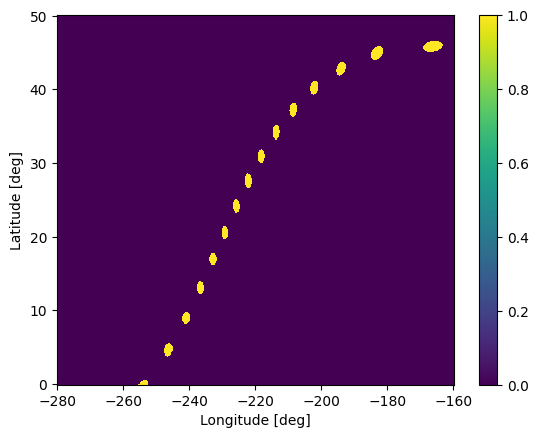

In [67]:
plt.figure()
plt.pcolor(L_grid_new * rad2deg, B_grid * rad2deg, eclipse_map_new)
plt.colorbar()
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")

#### Notice how this eclipse looks very similar to the previous one, example with its longitude shifted 120 degrees west. Let's plot both eclipses on the same map.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


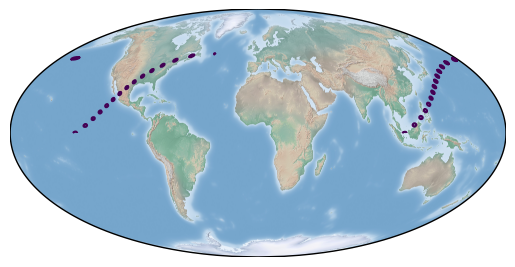

In [68]:
# setup basemap.
# set resolution=None to skip processing of boundary datasets.
map = Basemap(projection='moll',lon_0 = 0.0, resolution='c')
map.shadedrelief()
x_map_new, y_map_new = map(L_grid_new * rad2deg, B_grid * rad2deg)
x_map, y_map = map(L_grid * rad2deg, B_grid * rad2deg)
map.contour(x_map_new, y_map_new, eclipse_map_new, np.array([0.01]))
map.contour(x_map, y_map, eclipse_map, np.array([0.01]))
plt.show()

In [69]:
month_synodic * 223 

6585.321347

In [70]:
spice.kclear()

## PS01 Q4d

Eclipse duration at Austin: 105.13051307201385 seconds


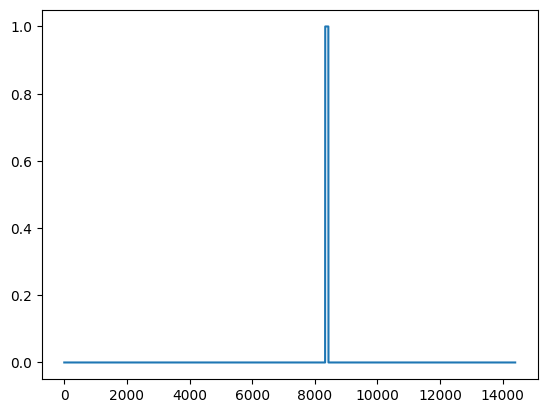

In [106]:
n_steps = 10000
# we are going to get positions between these two dates
t_start = '2024 APR 08 16:17:22.0000'
t_end   = '2024 APR 08 20:17:22.0000'

# get et values one and two, we could vectorize str2et
et_start = spice.str2et(t_start)
et_end   = spice.str2et(t_end)

# get times
times = np.linspace(et_start, et_end, n_steps)

state_sun  = np.zeros((6, len(times)))
state_moon = np.zeros((6, len(times)))

#Run spkpos as a vectorized function
for i in range(len(times)):
    state_sun[:,i], _  = spice.spkez(10, times[i], 'ITRF93', "LT+S", 399)
    state_moon[:,i], _ = spice.spkez(301, times[i], 'ITRF93', "LT+S", 399)

state_sun  = state_sun * 1e3
state_moon = state_moon * 1e3

lon_sun, lat_sun, r_sun    = coord.cart2sph(state_sun[0,:], state_sun[1,:], state_sun[2,:])
lon_moon, lat_moon, r_moon = coord.cart2sph(state_moon[0,:], state_moon[1,:], state_moon[2,:])

r_MS = np.sqrt((state_sun[0,:] - state_moon[0,:]) ** 2 +\
               (state_sun[1,:] - state_moon[1,:]) ** 2 +
               (state_sun[2,:] - state_moon[2,:]) ** 2)

d_shadow = (R_moon * r_MS) / (R_sun - R_moon)


# Austin, Texas Geodetic coordinates via google earth
B_ATX, L_ATX, H_ATX = 30.2672 * deg2rad, -97.7431 * deg2rad, 150.0
x_ATX, y_ATX, z_ATX = coord.BLH2XYZ(B_ATX, L_ATX, 
                                    H_ATX, a_ell, e_ell)
pos_austin = x_ATX, y_ATX, z_ATX

pos_shadow_tip = state_moon[0:3,:] + (state_moon[0:3,:] - state_sun[0:3,:]) / r_MS * d_shadow

# Check if Austin is within cone
eclipse = np.zeros(n_steps, dtype=int) # populate with 1s if eclipse occurs
for k in range(n_steps):
    h        = d_shadow[k]
    x        = pos_shadow_tip[:,k]
    v        = (state_moon[0:3,k] - x) / h
    cone_dir = (state_moon[0:3, k] - x) / h
    # Check if the Sun is above the horizon at Austin (correct side of Earth)
    N_sun, E_sun, U_sun = coord.XYZ2NEU(state_sun[0, k], state_sun[1, k], state_sun[2, k],
                                        x_ATX, y_ATX, z_ATX, a_ell, e_ell)
    sun_elev = np.arctan2(U_sun, np.sqrt(N_sun * N_sun + E_sun * E_sun))

    if sun_elev > 0 and is_in_cone(pos_austin, x, cone_dir, h, R_moon):
        eclipse[k] = 1

plt.figure()
plt.plot(times - times[0], eclipse)
plt.show

# Use transition point from 0 to 1 and 1 to 0 to identify entrance/exit time indeces
# ex - array will look like: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0] so this work
transitions = np.diff(eclipse)
entrance_i = np.where(transitions == 1)[0] 
exit_i     = np.where(transitions == -1)[0]

t_entrance = times[entrance_i[0]]
t_exit = times[exit_i[-1] + 1]  # use step after exit transition
print("Eclipse duration at Austin: " + str(t_exit - t_entrance) + " seconds")